## Customer segmentation of users based on their demographic information and credit score

## 1. Importing libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [19]:
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## 2. Reading and cleaning the data

In [42]:
a=pd.read_csv('census_credit.csv')

In [43]:
a.head()

,age,workclass,education,maritalstatus,occupation,race,sex,hoursperweek,nativecountry,credit_score_good_bad
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,40,Cuba,0


In [44]:
a.columns

Index(['age', 'workclass', 'education', 'maritalstatus', 'occupation', 'race',
       'sex', 'hoursperweek', 'nativecountry', 'credit_score_good_bad'],
      dtype='object')

In [45]:
#Null cleaning function 
def myfillna(series):
    if series.dtype is pd.np.dtype(float):
        return series.fillna('')
    elif series.dtype is pd.np.dtype(int):
        return series.fillna('')
    else:
        return series.fillna('NA')

In [46]:
a=a.apply(myfillna)

In [47]:
a.isnull().sum()

age                      0
workclass                0
education                0
maritalstatus            0
occupation               0
race                     0
sex                      0
hoursperweek             0
nativecountry            0
credit_score_good_bad    0
dtype: int64

In [48]:
a.shape
a.duplicated().sum()

(31978, 10)

5181

In [49]:
a.drop_duplicates(inplace = True)
a.shape

(26797, 10)

In [50]:
a['customer_id']=a.index

In [51]:
a.head()

,age,workclass,education,maritalstatus,occupation,race,sex,hoursperweek,nativecountry,credit_score_good_bad,customer_id
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,0,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,13,United-States,0,1
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,40,United-States,0,2
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,40,United-States,0,3
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,40,Cuba,0,4


In [52]:
countries = a['nativecountry'].value_counts()

## 3. Exploring the data

In [53]:
a.describe()

,age,hoursperweek,credit_score_good_bad,customer_id
count,26797.000000,26797.000000,26797.000000,26797.000000
mean,39.622458,40.653954,0.245438,15281.825391
std,13.765208,13.007499,0.430355,9285.496538
min,17.000000,1.000000,0.000000,0.000000
25%,29.000000,38.000000,0.000000,7116.000000
50%,38.000000,40.000000,0.000000,14952.000000
75%,49.000000,45.000000,0.000000,23219.000000
max,90.000000,99.000000,1.000000,31977.000000


In [54]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Count of people.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Countries of people',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [55]:
a.head()

,age,workclass,education,maritalstatus,occupation,race,sex,hoursperweek,nativecountry,credit_score_good_bad,customer_id
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,0,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,13,United-States,0,1
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,40,United-States,0,2
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,40,United-States,0,3
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,40,Cuba,0,4


In [56]:
a.education.unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [57]:
a.maritalstatus.unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [58]:
a.race.unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [61]:
a.hoursperweek.unique()

array([40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 43, 38, 55,
       48, 58, 32, 70,  2, 22, 56, 41, 28, 36, 24, 46, 42, 12, 65,  1, 10,
       34, 75, 98, 33, 54,  8,  6, 64, 19, 18, 72,  5,  9, 47, 37, 21, 26,
       14,  4,  7, 99, 53, 39, 62, 59, 57, 78, 90, 66, 11, 49, 84,  3, 17,
       68, 27, 85, 31, 51, 77, 63, 23, 87, 88, 73, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95], dtype=int64)

In [63]:
a.head(1)

,age,workclass,education,maritalstatus,occupation,race,sex,hoursperweek,nativecountry,credit_score_good_bad,customer_id
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,0,0


In [67]:
from sklearn.preprocessing import LabelEncoder

In [68]:
le = LabelEncoder()
le.fit(a['nativecountry'])

LabelEncoder()

In [69]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{' Cambodia': 0,
 ' Canada': 1,
 ' China': 2,
 ' Columbia': 3,
 ' Cuba': 4,
 ' Dominican-Republic': 5,
 ' Ecuador': 6,
 ' El-Salvador': 7,
 ' England': 8,
 ' France': 9,
 ' Germany': 10,
 ' Greece': 11,
 ' Guatemala': 12,
 ' Haiti': 13,
 ' Holand-Netherlands': 14,
 ' Honduras': 15,
 ' Hong': 16,
 ' Hungary': 17,
 ' India': 18,
 ' Iran': 19,
 ' Ireland': 20,
 ' Italy': 21,
 ' Jamaica': 22,
 ' Japan': 23,
 ' Laos': 24,
 ' Mexico': 25,
 ' Nicaragua': 26,
 ' Outlying-US(Guam-USVI-etc)': 27,
 ' Peru': 28,
 ' Philippines': 29,
 ' Poland': 30,
 ' Portugal': 31,
 ' Puerto-Rico': 32,
 ' Scotland': 33,
 ' South': 34,
 ' Taiwan': 35,
 ' Thailand': 36}

In [71]:
a['nativecountry'] = le.transform(a['nativecountry'])

In [72]:
a.head()

,age,workclass,education,maritalstatus,occupation,race,sex,hoursperweek,nativecountry,credit_score_good_bad,customer_id
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,40,38,0,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,13,38,0,1
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,40,38,0,2
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,40,38,0,3
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,40,4,0,4


In [73]:
le = LabelEncoder()
le.fit(a['workclass'])
a['workclass'] = le.transform(a['workclass'])

LabelEncoder()

In [75]:
le = LabelEncoder()
le.fit(a['education'])
a['education'] = le.transform(a['education'])

LabelEncoder()

In [76]:
a.head(1)

,age,workclass,education,maritalstatus,occupation,race,sex,hoursperweek,nativecountry,credit_score_good_bad,customer_id
0,39,7,9,Never-married,Adm-clerical,White,Male,40,38,0,0


In [83]:
a_clean = a[['age','workclass','education','hoursperweek','nativecountry','credit_score_good_bad']]

In [96]:
X=a_clean.iloc[:,0:5]

## 4. Implementing K-means for clustering the user base

In [111]:
scaler = StandardScaler()
X = scaler.fit_transform(a_clean)

In [112]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.25288048088143533 with Std Scaling
n_clusters = 3


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.2760347581191764 with Std Scaling
n_clusters = 4


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.27571091338658366 with Std Scaling
n_clusters = 5


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.28365031201896423 with Std Scaling
n_clusters = 6


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.25082363307808003 with Std Scaling
n_clusters = 7


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.2508781397380652 with Std Scaling
n_clusters = 8


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.25001533839958506 with Std Scaling
n_clusters = 9


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.24745200909151333 with Std Scaling
n_clusters = 10


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.22845237376002922 with Std Scaling
n_clusters = 11


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The average silhouette_score is : 0.23984036632176492 with Std Scaling


In [113]:
kmeans = KMeans(init='k-means++', n_clusters = 6, n_init=30, random_state=0)
kmeans.fit(X)
clusters = kmeans.predict(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=30, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

<Figure size 1440x576 with 0 Axes>

Text(0.5, 0, 'Cluster')

Text(0.5, 1.0, 'Number of customers per cluster')

([<matplotlib.axis.XTick at 0x28791d06198>,
 <a list of 8 Text xticklabel objects>)

Text(0, 5, '4924')

Text(0, 5, '2920')

Text(0, 5, '0')

Text(0, 5, '5786')

Text(0, 5, '8729')

Text(0, 5, '0')

Text(0, 5, '1264')

Text(0, 5, '3174')

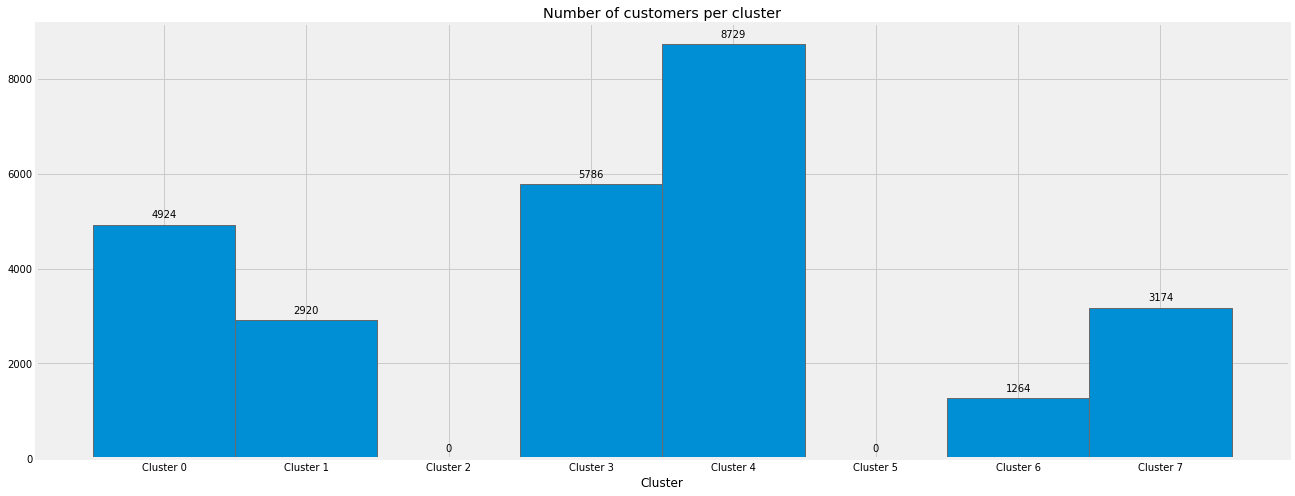

In [114]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [116]:
from sklearn.manifold import TSNE

In [ ]:
from sklearn.decomposition import PCA

In [129]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X)


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Visualization of customer clustering according to demographics and credit score')

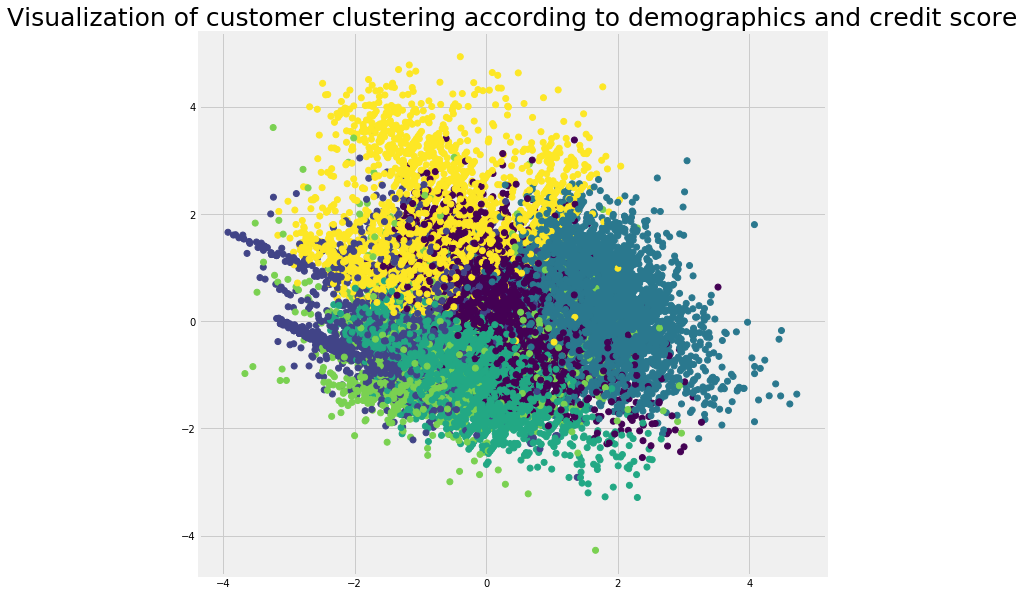

In [130]:
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of customer clustering according to demographics and credit score", fontsize="25")

In [137]:
from sklearn.model_selection import train_test_split

In [139]:
a_clean.head(1)

,age,workclass,education,hoursperweek,nativecountry,credit_score_good_bad
0,39,7,9,40,38,0


In [142]:
x_train, x_test, y_train, y_test= train_test_split(a_clean.iloc[:,0:5],a_clean['credit_score_good_bad'],test_size = 0.2 , random_state=11)

In [143]:
from sklearn.linear_model import LogisticRegression

In [144]:
logreg=LogisticRegression(penalty='l1')

In [145]:
logreg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [146]:
results = logreg.predict(x_test)

In [147]:
print("The accuracy score of the model is: %.3f" % (metrics.accuracy_score(y_test,results)))
print("The f1 score of the model is: %.3f" % (metrics.f1_score(y_test,results)))
print("The confusion matrix is:")
print(metrics.confusion_matrix(y_test,results))

The accuracy score of the model is: 0.750
The f1 score of the model is: 0.163
The confusion matrix is:
[[3890  140]
 [1200  130]]
